## Transfer learning

Create a neural network model to classify images of cats and dogs, using transfer learning: Use part of a pre-trained image classifier model (trained on ImageNet) as a feature extractor, and train additional new layers to perform the cats and dogs classification task.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



<img src="data/Cats-Dogs-Rex.jpg" alt="Drawing" style="height: 450px;" align="center"/>

#### The Dogs vs Cats dataset

Use the [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data), which was used for a 2013 Kaggle competition. It consists of 25000 images containing either a cat or a dog. We will only use a subset of 600 images and labels. The dataset is a subset of a much larger dataset of 3 million photos that were originally used as a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart).

#### Load and preprocess the data

In [3]:
images_train = np.load('data/images_train.npy') / 255.
images_valid = np.load('data/images_valid.npy') / 255.
images_test = np.load('data/images_test.npy') / 255.

labels_train = np.load('data/labels_train.npy')
labels_valid = np.load('data/labels_valid.npy')
labels_test = np.load('data/labels_test.npy')

In [4]:
print("{} training data examples".format(images_train.shape[0]))
print("{} validation data examples".format(images_valid.shape[0]))
print("{} test data examples".format(images_test.shape[0]))

600 training data examples
300 validation data examples
300 test data examples


#### Display sample images and labels from the training set

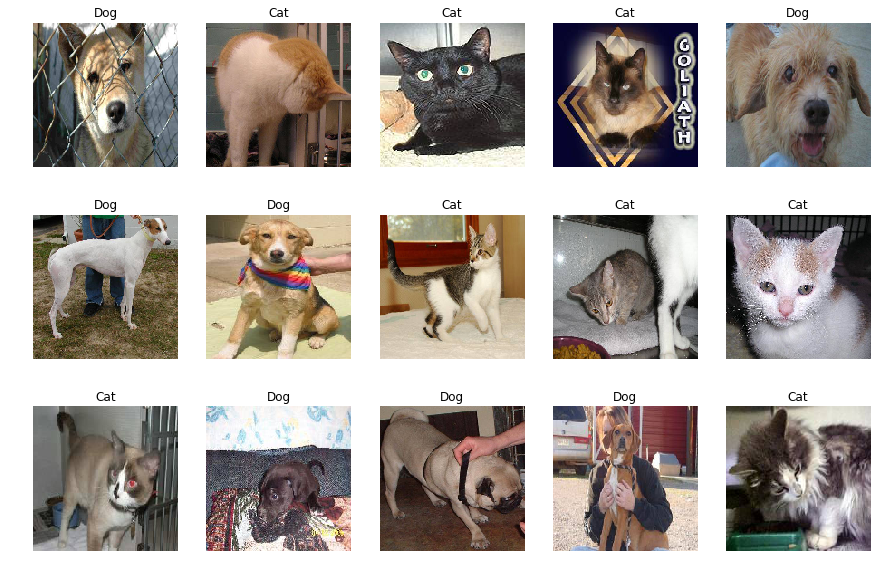

In [5]:
# Display a few images and labels

class_names = np.array(['Dog', 'Cat'])

plt.figure(figsize=(15,10))
inx = np.random.choice(images_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(images_train[i])
    plt.title(class_names[labels_train[i]])
    plt.axis('off')

#### Create a benchmark model
Train a CNN classifier model as a benchmark model before implementing the transfer learning approach. Using the functional API, build the benchmark model:

In [6]:
def get_benchmark_model(input_shape):
        
    inputs=Input(shape=input_shape)
    x=Conv2D(32,3,padding='SAME',activation='relu')(inputs)
    x=Conv2D(32,3,padding='SAME',activation='relu')(x)
    x=MaxPooling2D((2,2))(x)
    x=Conv2D(64,3,padding='SAME',activation='relu')(x)
    x=Conv2D(64,3,padding='SAME',activation='relu')(x)
    x=MaxPooling2D((2,2))(x)
    x=Conv2D(128,3,padding='SAME',activation='relu')(x)
    x=Conv2D(128,3,padding='SAME',activation='relu')(x)
    x=MaxPooling2D((2,2))(x)
    x=Flatten()(x)
    x=Dense(128,activation='relu')(x)
    outputs=Dense(1,activation='sigmoid')(x)
    
    model=tf.keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(tf.keras.optimizers.RMSprop( 0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
    )
    
    return model

In [7]:
benchmark_model = get_benchmark_model(images_train[0].shape)
benchmark_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0     

#### Train the CNN benchmark model

In [8]:
# Fit the benchmark model and save its training history

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_benchmark = benchmark_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                        validation_data=(images_valid, labels_valid), 
                                        callbacks=[earlystopping])

Train on 600 samples, validate on 300 samples
Epoch 1/10
600/600 [==============================] - 450s 751ms/sample - loss: 2.4492 - accuracy: 0.4867 - val_loss: 0.6903 - val_accuracy: 0.5333
Epoch 2/10
600/600 [==============================] - 445s 742ms/sample - loss: 0.6936 - accuracy: 0.4883 - val_loss: 0.6918 - val_accuracy: 0.5433
Epoch 3/10
600/600 [==============================] - 438s 729ms/sample - loss: 0.6971 - accuracy: 0.5433 - val_loss: 0.6927 - val_accuracy: 0.5033


#### Plot the learning curves

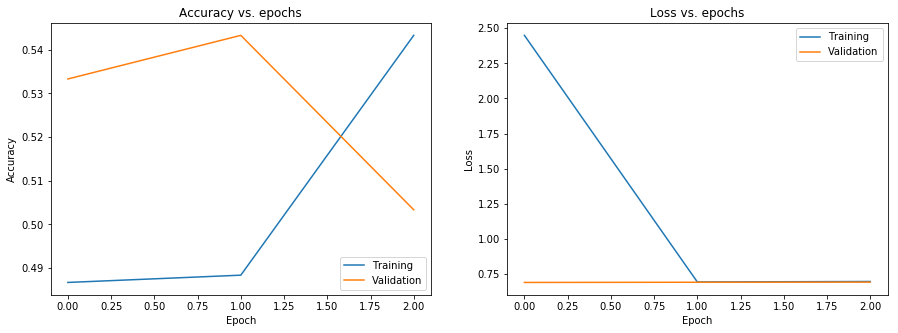

In [9]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_benchmark.history['accuracy'])
    plt.plot(history_benchmark.history['val_accuracy'])
except KeyError:
    plt.plot(history_benchmark.history['acc'])
    plt.plot(history_benchmark.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Evaluate the benchmark model

In [10]:
# Evaluate the benchmark model on the test set

benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(benchmark_test_loss))
print("Test accuracy: {}".format(benchmark_test_acc))

Test loss: 0.6928019515673319
Test accuracy: 0.503333330154419


#### Load the pretrained image classifier model
Begin to build the image classifier using transfer learning.
Use the pre-trained MobileNet V2 model, available to download from [Keras Applications](https://keras.io/applications/#mobilenetv2). However, I have already downloaded the pretrained model for you, and it is available at the location `./models/MobileNetV2.h5`.

In [11]:
def load_pretrained_MobileNetV2(path):
      
    model = load_model(path)
    
    return model

In [12]:
# loading the pretrained model and display its summary

base_model = load_pretrained_MobileNetV2('models/MobileNetV2.h5')
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

#### Use the pre-trained model as a feature extractor

Remove the final layer of the network and replace it with new, untrained classifier layers for the task.first create a new model that has the same input tensor as the MobileNetV2 model, and uses the output tensor from the layer with name `global_average_pooling2d_6` as the model output.

In [13]:
def remove_head(pretrained_model):
        
    model = Model(inputs=pretrained_model.input, 
                  outputs=pretrained_model.get_layer('global_average_pooling2d_6').output)
    
    return model

In [14]:
# Removing the classification head and display the summary

feature_extractor = remove_head(base_model)
feature_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

Construct new final classifier layers for the model:

In [15]:
def add_new_classifier_head(feature_extractor_model):
       
    model = Sequential([
                        feature_extractor_model,
                        Dense(32, activation='relu'),
                        Dropout(0.5),
                        Dense(1, activation='sigmoid')
                        ])
    
    return model

In [16]:
# Adding a new classification head and display the summary

new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                40992     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,299,009
Trainable params: 2,264,897
Non-trainable params: 34,112
_________________________________________________________________


#### Freeze the weights of the pretrained model

Freeze the weights of the pre-trained feature extractor, so that only the weights of the new layers. 

In [17]:
def freeze_pretrained_weights(model):
   
    model.layers[0].trainable = False

    model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
             loss = 'binary_crossentropy',
             metrics = ['acc'])
    return model
    

In [18]:
# Freezing the pretrained weights and display the summary

frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                40992     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,299,009
Trainable params: 41,025
Non-trainable params: 2,257,984
_________________________________________________________________


#### Train the model

In [19]:
# Train the model and save its training history

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_frozen_new_model = frozen_new_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                                validation_data=(images_valid, labels_valid), 
                                                callbacks=[earlystopping])

Train on 600 samples, validate on 300 samples
Epoch 1/10
600/600 [==============================] - 175s 291ms/sample - loss: 0.4887 - acc: 0.7717 - val_loss: 0.1812 - val_acc: 0.9433
Epoch 2/10
600/600 [==============================] - 173s 288ms/sample - loss: 0.2888 - acc: 0.8633 - val_loss: 0.2165 - val_acc: 0.9033
Epoch 3/10
600/600 [==============================] - 167s 278ms/sample - loss: 0.2585 - acc: 0.8833 - val_loss: 0.1774 - val_acc: 0.9200
Epoch 4/10
600/600 [==============================] - 164s 274ms/sample - loss: 0.1937 - acc: 0.9133 - val_loss: 0.1470 - val_acc: 0.9500
Epoch 5/10
600/600 [==============================] - 162s 270ms/sample - loss: 0.1799 - acc: 0.9183 - val_loss: 0.2563 - val_acc: 0.9000
Epoch 6/10
600/600 [==============================] - 164s 273ms/sample - loss: 0.1604 - acc: 0.9350 - val_loss: 0.1322 - val_acc: 0.9600
Epoch 7/10
600/600 [==============================] - 163s 271ms/sample - loss: 0.1819 - acc: 0.9250 - val_loss: 0.3176 - val_

#### Plot the learning curves

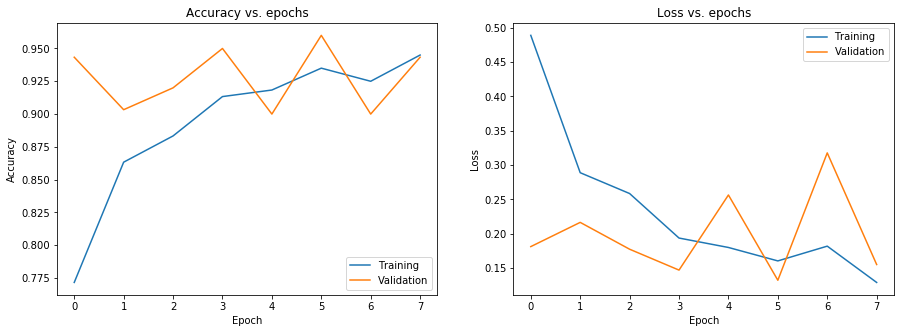

In [20]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_frozen_new_model.history['accuracy'])
    plt.plot(history_frozen_new_model.history['val_accuracy'])
except KeyError:
    plt.plot(history_frozen_new_model.history['acc'])
    plt.plot(history_frozen_new_model.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Evaluate the new model

In [21]:
# Evaluate the benchmark model on the test set

new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(new_model_test_loss))
print("Test accuracy: {}".format(new_model_test_acc))

Test loss: 0.1178074995179971
Test accuracy: 0.9466666579246521


## Test accuracy: 94 %

#### Compare both models

In [22]:
# Gather the benchmark and new model metrics

benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]

try:
    benchmark_train_acc = history_benchmark.history['acc'][-1]
    benchmark_valid_acc = history_benchmark.history['val_acc'][-1]
except KeyError:
    benchmark_train_acc = history_benchmark.history['accuracy'][-1]
    benchmark_valid_acc = history_benchmark.history['val_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]

try:
    new_model_train_acc = history_frozen_new_model.history['acc'][-1]
    new_model_valid_acc = history_frozen_new_model.history['val_acc'][-1]
except KeyError:
    new_model_train_acc = history_frozen_new_model.history['accuracy'][-1]
    new_model_valid_acc = history_frozen_new_model.history['val_accuracy'][-1]

In [23]:
# Compile the metrics into a pandas DataFrame and display the table

comparison_table = pd.DataFrame([['Training loss', benchmark_train_loss, new_model_train_loss],
                                ['Training accuracy', benchmark_train_acc, new_model_train_acc],
                                ['Validation loss', benchmark_valid_loss, new_model_valid_loss],
                                ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc],
                                ['Test loss', benchmark_test_loss, new_model_test_loss],
                                ['Test accuracy', benchmark_test_acc, new_model_test_acc]],
                               columns=['Metric', 'Benchmark CNN', 'Transfer learning CNN'])
comparison_table.index=['']*6
comparison_table

,Metric,Benchmark CNN,Transfer learning CNN
,Training loss,0.697117,0.129021
,Training accuracy,0.543333,0.945000
,Validation loss,0.692736,0.155112
,Validation accuracy,0.503333,0.943333
,Test loss,0.692802,0.117807
,Test accuracy,0.503333,0.946667


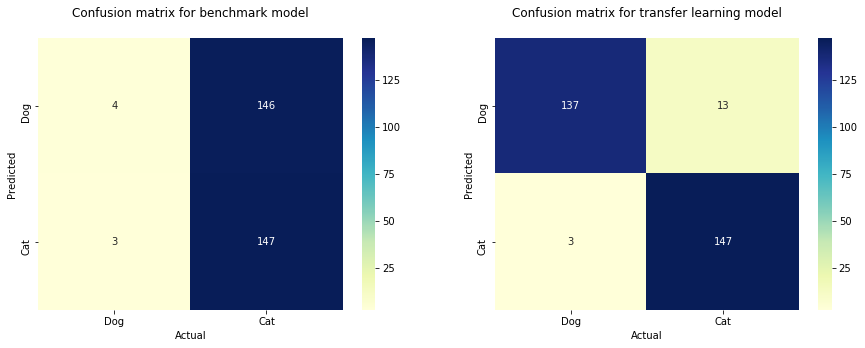

In [24]:
# Plot confusion matrices for benchmark and transfer learning models

plt.figure(figsize=(15, 5))

preds = benchmark_model.predict(images_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(labels_test, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(121)
plt.title("Confusion matrix for benchmark model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

preds = frozen_new_model.predict(images_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(labels_test, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(122)
plt.title("Confusion matrix for transfer learning model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()